#  ASSIGNMENT BACKGROUND

  * We are working for a media buying company who recently acquired a new client in the health industry.
  * This client is interested in using contextual advertising to reach consumers who value health and wellness.
  * This client needs help identifying as many news articles as possible where they could succesfully advertise on.

### TASK:
  * Build a deep learning algorithm that predicts the probability that a news story is about health and wellness.

### DATA:
  * Our data consists of 200,000 news headlines (2012 - 2018) from HuffPost.
  * The categories we are working with are listed below.
    * Each category is noted with its respective count. In other words, how many times an article under this category appears within our data set.


        POLITICS - 32739
        WELLNESS - 17827
        ENTERTAINMENT - 16058
        TRAVEL - 9887
        STYLE & BEAUTY - 9649
        PARENTING - 8677
        HEALTHY LIVING - 6694
        QUEER VOICES - 6314
        FOOD & DRINK - 6226
        BUSINESS - 5937
        COMEDY - 5175
        SPORTS - 4884
        BLACK VOICES - 4195
        PARENTS - 3955
        THE WORLDPOST - 3664
        WEDDINGS - 3651
        WOMEN - 3490
        IMPACT - 3459
        DIVORCE - 3426
        CRIME - 3405
        MEDIA - 2815
        WEIRD NEWS - 2670
        GREEN - 2622
        WORLDPOST - 2579
        RELIGION - 2556
        STYLE - 2254
        WORLD NEWS - 2177
        TASTE - 2096
        TECH - 2082
        MONEY - 1707
        ARTS - 1509
        FIFTY - 1401
        GOOD NEWS - 1398
        ARTS & CULTURE - 1339
        ENVIRONMENT - 1323
        COLLEGE - 1141
        LATINO VOICES - 1129
        CULTURE & ARTS - 1030
        EDUCATION - 1004

### EVALUATION:

    Benchmark Classification Report:

            precision    recall  f1-score   support

       0       0.88      0.84       0.86       669
       1       0.85      0.89       0.87       670

    accuracy                        0.86      1339

    macro avg    0.86     0.86      0.86      1339

    weighted avg 0.86     0.86      0.86      1339


* The performance of our model will be measured against the Benchmark Classification Report. 
* Since our cases are extremely imbalanced, we are more interested in maximizing the F1-Score with regards to the positive case '1'. 
* We also want to capture as many of the positive cases as we can from the positive case pool, in which case we are also very interested in maximizing our positive case Recall.

### 1.) Importing Libraries and Setting GPU Runtime

In [ ]:
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
print(tf.__version__)
try:
  import ktrain
except:
  !pip install ktrain
  os.kill(os.getpid(),9)
from ktrain import text
from ktrain.text import texts_from_df
import time
import pandas as pd
from keras.preprocessing.text import Tokenizer
import pickle
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow

np.random.seed(5)

2.9.2


In [ ]:
# Mount in order to interact with files inside the Drive.

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ROOT_D = "/content/drive/MyDrive/projects/Text_Classification"
DATA_D = "%s/data" % ROOT_D
MOD_D = "%s/models" % ROOT_D


dat_exist = os.path.exists(DATA_D)
if not dat_exist:
  os.makedirs(DATA_D)
 
mod_exist = os.path.exists(MOD_D)
if not mod_exist:
  os.makedirs(MOD_D)

  

* Make sure the cell below outputs information about GPU before moving forward.
  - If GPU is not set, go to "Runtime" -> "Change Runtime Type" -> Select GPU
  - Select Re-Run on Runtime if adjustment had to be made.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print("Not Connected to GPU")
else:
  print(gpu_info)

Sat Dec 10 15:13:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget http://128.138.93.164/news_category_trainingdata.json -P /content/drive/MyDrive/projects/Text_Classification/data

--2022-12-10 15:13:48--  http://128.138.93.164/news_category_trainingdata.json
Connecting to 128.138.93.164:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78875614 (75M) [application/json]
Saving to: ‘/content/drive/MyDrive/projects/Text_Classification/data/news_category_trainingdata.json.1’

news_category_train 100%[===================>]  75.22M  19.9MB/s    in 4.0s    

2022-12-10 15:13:52 (18.8 MB/s) - ‘/content/drive/MyDrive/projects/Text_Classification/data/news_category_trainingdata.json.1’ saved [78875614/78875614]



In [ ]:
raw_data = pd.read_json('%s/news_category_trainingdata.json' % DATA_D)

In [ ]:
#------ Initial Observations:

# Checking the shape:
print("---"*5)
print(raw_data.shape)

# Checking the first three rows:
print(raw_data.head(3))

# From our initial observation we can see that two of the columns contain text data.
# We are going to combine these into one single column and explore our data a little further.
raw_data['TEXT_col'] = raw_data['headline']+' '+raw_data['short_description']
raw_data['TARGET_col'] = np.where(raw_data['category']=='HEALTHY LIVING',1,0)

print(raw_data['TARGET_col'].value_counts())
print(raw_data['TARGET_col'].describe())

---------------
(200853, 6)
        category                                           headline  \
0          CRIME  There Were 2 Mass Shootings In Texas Last Week...   
1  ENTERTAINMENT  Will Smith Joins Diplo And Nicky Jam For The 2...   
2  ENTERTAINMENT    Hugh Grant Marries For The First Time At Age 57   

           authors                                               link  \
0  Melissa Jeltsen  https://www.huffingtonpost.com/entry/texas-ama...   
1    Andy McDonald  https://www.huffingtonpost.com/entry/will-smit...   
2       Ron Dicker  https://www.huffingtonpost.com/entry/hugh-gran...   

                                   short_description       date  
0  She left her husband. He killed their children... 2018-05-26  
1                           Of course it has a song. 2018-05-26  
2  The actor and his longtime girlfriend Anna Ebe... 2018-05-26  
0    194159
1      6694
Name: TARGET_col, dtype: int64
count    200853.000000
mean          0.033328
std           0.179492
min   

### Problem 1

* We can see from the table above that our positive case only covers about 3% of all samples.
* This imbalance is going to be addressed through Undersampling of the majority case.

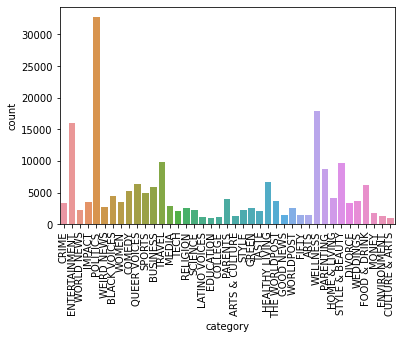

In [ ]:
# Before we do anything else, lets take a look at the distribution in our categories one more time.
sns.countplot(x='category',data=raw_data)
plt.xticks(rotation='vertical')
plt.show()

### Problem 2
* we can see that the 'WELLNESS' category is the 2nd most common category type with a count of over 17,000 articles. Our category of interest 'HEALTHY LIVING' has a count of only 6694.
* This poses a potential problem to our overall objective of capturing specifically those consumers who would be interested in a product specifically related to living a healthy lifestyle. 
  - This is because the wellness category introduces noise into our data set by including articles which have little to do with healthy living.
* This issue will be addressed through elimination of the 'Wellness' category from ONLY our training data.
 - We retain this category in our final testing phase in order to better align with real-world circumstances.



In [ ]:
np.random.seed(5)

# Our utilization variable controls how much of the total data we are going to be using.
# Since the notebook is only run once, the variable is set to 100% utilization.
utilization = 1
print("Structure prior to Sampling:")
print(raw_data['TARGET_col'].value_counts())
print(raw_data['TARGET_col'].describe())
print("---")

sample_n = int((len(raw_data[raw_data['TARGET_col']==1]))*utilization)

target = raw_data[raw_data['TARGET_col']==1].sample(n=sample_n,random_state=5)
not_target = raw_data[raw_data['TARGET_col']==0].sample(n=sample_n,random_state=5)

bal_df = pd.concat([target,not_target])
bal_df = bal_df[['category','TEXT_col','TARGET_col']]
bal_df.describe()
print("After balance / utilization cut:")
print(bal_df['TARGET_col'].value_counts())
print(bal_df['TARGET_col'].describe())
print("---")



Structure prior to Sampling:
0    194159
1      6694
Name: TARGET_col, dtype: int64
count    200853.000000
mean          0.033328
std           0.179492
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: TARGET_col, dtype: float64
---
After balance / utilization cut:
1    6694
0    6694
Name: TARGET_col, dtype: int64
count    13388.000000
mean         0.500000
std          0.500019
min          0.000000
25%          0.000000
50%          0.500000
75%          1.000000
max          1.000000
Name: TARGET_col, dtype: float64
---


### 2.) Train Test Split

In [ ]:


#-----------------------------------------------
# Splitting our data into Train / Test Set, allocating 10% for testing.

def do_split(_df):

  balanced_df = _df.copy()
  x_train, x_test, y_train, y_test = train_test_split(balanced_df[['category','TEXT_col']]
                                                    ,balanced_df[['category','TARGET_col']]
                                                    ,test_size=.10
                                                    ,random_state=1
                                                    ,stratify=balanced_df['TARGET_col'])
  print("x_train_shape: ",x_train.shape)
  print("y_train_shape: ",y_train.shape)
  print("x_test_shape: ",x_test.shape)
  print("y_test_shape: ",y_test.shape)


  x_train_modified = x_train.copy()
  y_train_modified = y_train.copy()

  print('#-------------------------------------------------------------#')
  # EXCLUDING WELLNESS HERE:

  drp_idx = x_train_modified[(x_train_modified['category']=='WELLNESS')].index

  x_train_modified.drop(drp_idx,inplace=True)

  drp_idx = y_train_modified[(y_train_modified['category']=='WELLNESS')].index

  y_train_modified.drop(drp_idx,inplace=True)


  #-------------------------------------------------------------#
  print("x_trainM_shape: ",x_train_modified.shape)
  print("y_trainM_shape: ",y_train_modified.shape)
  print("x_test_shape: ",x_test.shape)
  print("y_test_shape: ",y_test.shape)

  d1 = {'xtest':x_test['TEXT_col']
        ,'label':y_test['TARGET_col']}
  test_df = pd.DataFrame(data=d1)
  test_df = test_df.reset_index()

  d2 = {'train':x_train['TEXT_col']
        ,'label':y_train['TARGET_col']}
  train_df = pd.DataFrame(data=d2)
  train_df = train_df.reset_index()

  d3 = {'train':x_train_modified['TEXT_col']
        ,'label':y_train_modified['TARGET_col']}
  train_df_M = pd.DataFrame(data=d3)
  train_df_M = train_df_M.reset_index()

  #-------------------------------------------------------------#
  print("Original Training Data:")
  print(train_df.shape)
  print(train_df['label'].describe())
  train_df.head(3)

  print("Modified Training Data:")
  print(train_df_M.shape)
  print(train_df_M['label'].describe())
  train_df_M.head(3)


  test_df.to_feather("%s/TEST_DF.feather" % DATA_D)
  train_df.to_feather("%s/TRAIN_DF.feather" % DATA_D)
  train_df_M.to_feather("%s/TRAIN_DF_MOD.feather" % DATA_D)

do_split(bal_df)

x_train_shape:  (12049, 2)
y_train_shape:  (12049, 2)
x_test_shape:  (1339, 2)
y_test_shape:  (1339, 2)
#-------------------------------------------------------------#
x_trainM_shape:  (11507, 2)
y_trainM_shape:  (11507, 2)
x_test_shape:  (1339, 2)
y_test_shape:  (1339, 2)
Original Training Data:
(12049, 3)
count    12049.000000
mean         0.499959
std          0.500021
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: label, dtype: float64
Modified Training Data:
(11507, 3)
count    11507.000000
mean         0.523507
std          0.499469
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: label, dtype: float64


### 3.) Building and Tuning Model
  * We are going to be using the Distilbert model here, a lighter version of Bert with exquisite performance in speed and accuracy relative to other models.
  * We are also allocating additional 10% of our data for validation throughout the tuning process. Our original testing set will be used to guage to final measure in performance.
  * Learning rate is selected based on minimal loss according to plot.
  * In order to prevent over/underfitting of the model, autofit will be utilized along with early stopping.

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Model_A Labels: 
count    11507.000000
mean         0.523507
std          0.499469
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: label, dtype: float64
['not_label', 'label']
      not_label  label
1282        0.0    1.0
9488        0.0    1.0
3105        1.0    0.0
687         0.0    1.0
9704        0.0    1.0
['not_label', 'label']
      not_label  label
7617        0.0    1.0
3354        0.0    1.0
1856        1.0    0.0
2201        0.0    1.0
9681        0.0    1.0
preprocessing train...
language: en
train sequence lengths:
	mean : 28
	95percentile : 58
	99percentile : 70


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 28
	95percentile : 58
	99percentile : 72


Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

simulating training for different learning rates... this may take a few moments...
Epoch 1/6
647/647 [==============================] - 592s 895ms/step - loss: 0.6484 - accuracy: 0.6720
Epoch 2/6
647/647 [==============================] - 585s 904ms/step - loss: 0.3055 - accuracy: 0.8794
Epoch 3/6
647/647 [==============================] - 584s 902ms/step - loss: 0.3865 - accuracy: 0.8142
Epoch 4/6
647/647 [==============================] - 577s 892ms/step - loss: 0.6968 - accuracy: 0.5185
Epoch 5/6
647/647 [==============================] - 189s 292ms/step - loss: 21.8955 - accuracy: 0.5027


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


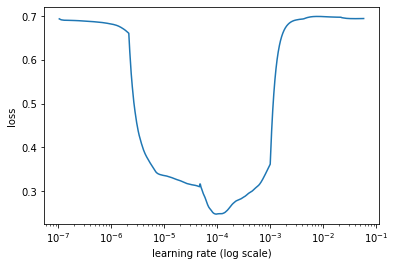



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/12
648/648 [==============================] - 602s 914ms/step - loss: 0.3145 - accuracy: 0.8729 - val_loss: 0.2396 - val_accuracy: 0.9001
Epoch 2/12
648/648 [==============================] - 592s 910ms/step - loss: 0.1664 - accuracy: 0.9384 - val_loss: 0.2498 - val_accuracy: 0.9010
Epoch 2: early stopping
Weights from best epoch have been loaded into model.
36/36 [==============================] - 7s 149ms/step
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       557
           1       0.88      0.93      0.91       594

    accuracy                           0.90      1151
   macro avg       0.90      0.90      0.90      1151
weighted avg       0.90      0.90      0.90      1151



In [ ]:

def model_A():
  tf.keras.backend.clear_session()
 
  np.random.seed(1)

  target_names = ['not_label','label']

  t = text.Transformer('distilbert-base-uncased',maxlen=512,class_names=target_names)

  dat = pd.read_feather("%s/TRAIN_DF_MOD.feather" % DATA_D)

  print("Model_A Labels: ")
  print(dat['label'].describe())
               
  trn_dat, val_dat, preproc = text.texts_from_df(train_df=dat
                                                 ,text_column='train'
                                                 ,label_columns=['label']
                                                 ,max_features = 35000
                                                 ,maxlen = 512
                                                 ,val_pct=0.1
                                                 ,random_state=1
                                                 ,ngram_range=2
                                                 ,preprocess_mode='distilbert'
                                                 ,verbose=1)

  model = preproc.get_classifier()

  learner = ktrain.get_learner(model
                             , train_data=trn_dat
                             , val_data=val_dat
                             , batch_size=16)
 
  #____________________________

  learner.lr_find(max_epochs=6)

  learner.lr_plot()

  history = learner.autofit(1e-4,checkpoint_folder='checkpoint',epochs=12,early_stopping=True)

  predictor = ktrain.get_predictor(learner.model,preproc=preproc)
  predictor.save("%s/model_A_Predictor" % MOD_D)

  validation = learner.validate(val_data=val_dat,print_report=True)
  #____________________________
  # Here we are comparing the validation accuracy and F1-Score to benchmark.
  # Next, predictions will be made on Test data.

model_A()


### 4.) Predicting on the holdout-set
  * The validation Accuracy and F1 Score are higher than benchmark by 4%
  * In this case, this would be the testing set.
  * The predictor is constructed using the get_predictor method, which takes the model and preproc object as inputs.


In [ ]:
def get_results():
  act = pd.read_feather("%s/TEST_DF.feather" % DATA_D)
  mod1 = ktrain.load_predictor("%s/model_A_Predictor" % MOD_D)
  p = mod1.predict(act['xtest'].tolist())
  def get_predicted(_res):
    pr = []
    for r in _res:
      if r=='label':
        pr.append(1)
      else:
        pr.append(0)
    return pr

  predicted = get_predicted(p)
  actuals = act['label'].tolist()
  print(metrics.classification_report(actuals,predicted))
get_results()


def get_prob(_text):
  mod1 = ktrain.load_predictor("%s/model_A_Predictor" % MOD_D)
  proba = mod1.predict_proba(_text)
  return "Healthy Living probability: "+str(round(proba[1],2))


# As an additional test, we are running a prediction on an arbitrary 'healthy living' related string.
some_text = 'This is a healthy lifestyle article.'
get_prob(some_text)



42/42 [==============================] - 7s 130ms/step
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       669
           1       0.85      0.94      0.89       670

    accuracy                           0.89      1339
   macro avg       0.89      0.89      0.89      1339
weighted avg       0.89      0.89      0.89      1339

1/1 [==============================] - 2s 2s/step


'Healthy Living probability: 0.97'

### EVALUATION
  * After reviewing the results of our Testing Set Classification report, it is clear that our algorithm exceeded all Benchmark targets. More specifically, we see improvements in the following areas with regards to our positive case:
  
    * +5% improvement in Recall of the Positive case.
    * +3% improvement in Accuracy
    * +2% improvement in F1-Score